# ASTR 596: FDS Homework 6: Hunting for Exoplanets


### If you are watching Star Trek: Picard, then you might wonder about the "Admonition" - a warning/message left in an octuple planet system about past synthetic life in the Galaxy.

### [Ethan Siegel's Starts With a Bang blog has even covered it](https://www.forbes.com/sites/startswithabang/2020/03/19/is-star-trek-picards-hypothesized-octuple-star-system-really-possible/)

### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg">


### But is there a system with 8 planets??? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with `gatspy`. 


### To get the Kepler data, you'll need the `lightkurve` package

> `conda install lightkurve`

### I've included some code to get the light curve, clean it and remove the NaNs, but not outliers (you can judge the wisdom of outlier removal when you are hunting for planets).


<hr>

#### Hints:

* `gatspy` has a `predict` method that you can use to get a model light curve for some period (you should need no more 3-5 terms). You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next.

* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html)

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [1]:
%matplotlib inline
import lightkurve as lk
import gatspy
import numpy as np
import gatspy as gp
import matplotlib.pyplot as plt
from astropy import units as u
from scipy.signal import find_peaks

# changing default font sizes and family
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Cambria' #'serif' Cambria, Times New Roman, Georgia

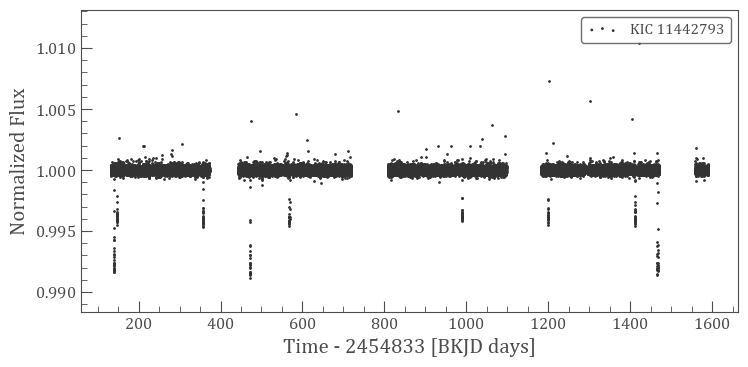

In [2]:
lcfs = lk.search_lightcurvefile('Kepler-90', mission='Kepler').download_all()

def squelch_rednoise(lc):
    corrected_lc = lc.normalize().flatten(window_length=51)
    return corrected_lc

stitched_lc = lcfs.PDCSAP_FLUX.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans()

clc.scatter();
#clc.plot()

# Mel practicing with tutorials (not homework yet)

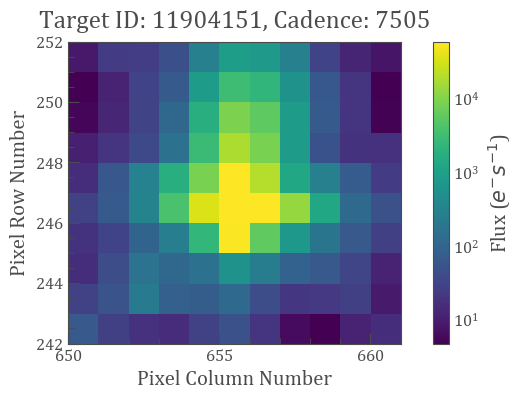

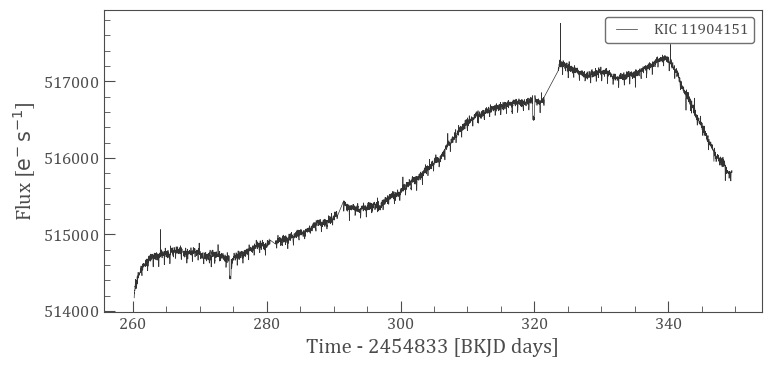

In [3]:
# recover planet from Kepler-10 tutorial
tpf = lk.search_targetpixelfile("Kepler-10", quarter=3).download()
tpf.plot(frame=100, scale='log', show_colorbar=True)
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
lc.plot()

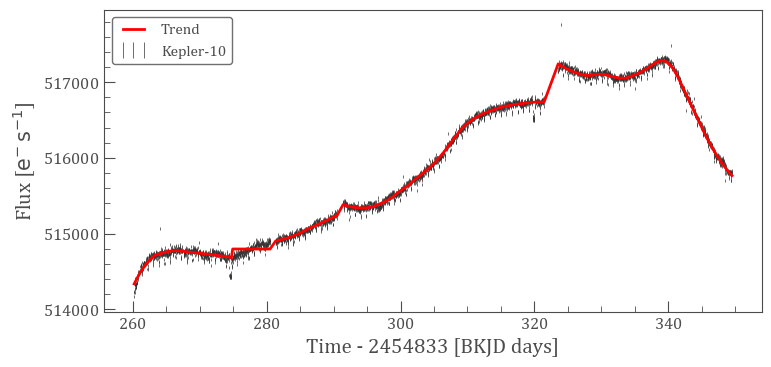

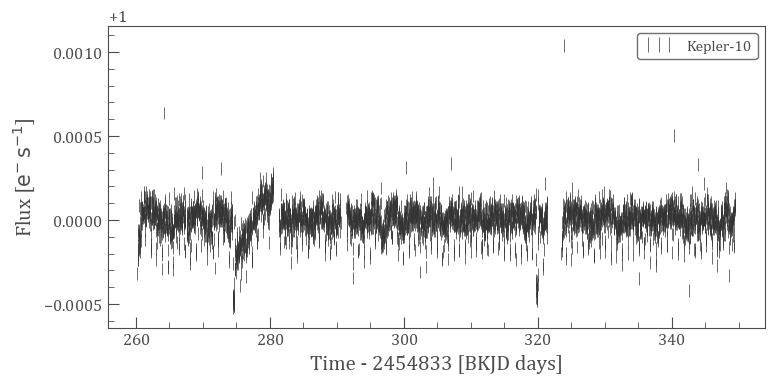

In [4]:
flat, trend = lc.flatten(window_length=301, return_trend=True)
ax = lc.errorbar(label="Kepler-10")
trend.plot(ax=ax, color='red', lw=2, label='Trend')

flat.errorbar(label="Kepler-10")

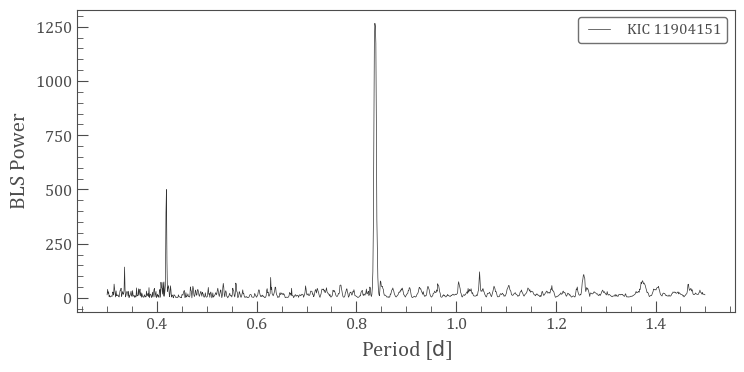

In [5]:
periodogram = flat.to_periodogram(method="bls", period=np.arange(0.3, 1.5, 0.001))
periodogram.plot()

Lightkurve tutorial best fit period: 0.837 d


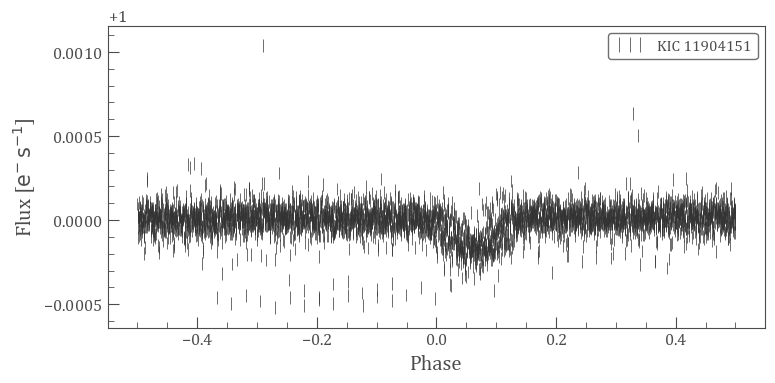

In [6]:
best_fit_period = periodogram.period_at_max_power
print('Lightkurve tutorial best fit period: {:.3f}'.format(best_fit_period))
flat.fold(period=best_fit_period, t0=periodogram.transit_time_at_max_power).errorbar()

# HOMEWORK BELOW HERE

## First planet

`period` contains 2837711 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


Kepler-90 planet 1 best fit period: 331.604 d


Text(0.5, 1.0, '1st planet found')

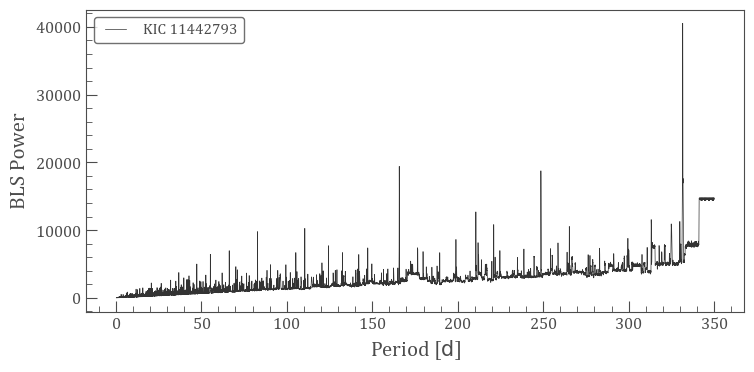

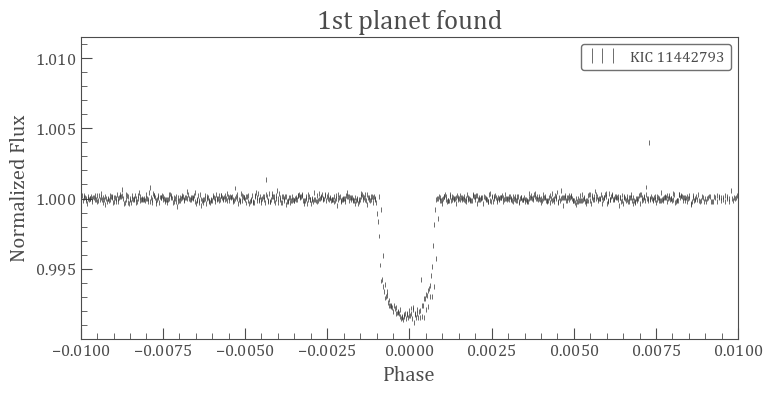

In [7]:
clc_periodo = clc.to_periodogram(method="bls", period=np.linspace(0.3, 350, 10000))
clc_periodo.plot()

clc_bestfit = clc_periodo.period_at_max_power
print('Kepler-90 planet 1 best fit period: {:.3f}'.format(clc_bestfit))
ax = clc.fold(period=clc_bestfit, t0=clc_periodo.transit_time_at_max_power).errorbar()
ax.set_xlim(-0.01, 0.01)
ax.set_title('1st planet found')

## Mask transit from 1st planet

`period` contains 2837711 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


Text(0.5, 1.0, 'Periodogram after 1st mask of transit from 1st planet')

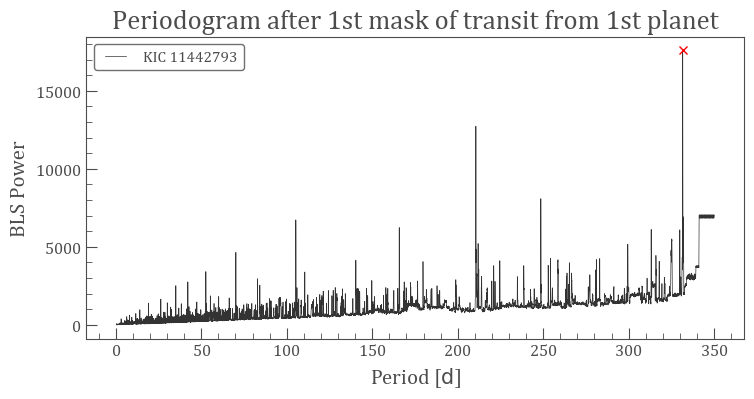

In [8]:
lc_mask = clc_periodo.get_transit_mask(period=clc_periodo.period_at_max_power, 
                                      duration=clc_periodo.duration_at_max_power,
                                      transit_time=clc_periodo.transit_time_at_max_power)
clc_rem = clc[lc_mask]

rem_periodo = clc_rem.to_periodogram(method="bls", period=np.linspace(0.3, 350, 10000))
ax = rem_periodo.plot()
ax.plot(rem_periodo.period_at_max_power, rem_periodo.max_power, 'rx')
ax.set_title('Periodogram after 1st mask of transit from 1st planet')

In [9]:
rem_bestfit = rem_periodo.period_at_max_power
print('Kepler-90 searching for planet 2 best fit period: {:.3f}'.format(rem_bestfit))

Kepler-90 searching for planet 2 best fit period: 331.604 d


Oops! Hmm... this 331.604 d period is strong. Let's keep masking it until the new max power does not correspond to a period of 331.604 d.

### 2nd mask, 1st planet

`period` contains 2837711 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


Text(0.5, 1.0, 'Periodogram after 2nd mask of transit from 1st planet')

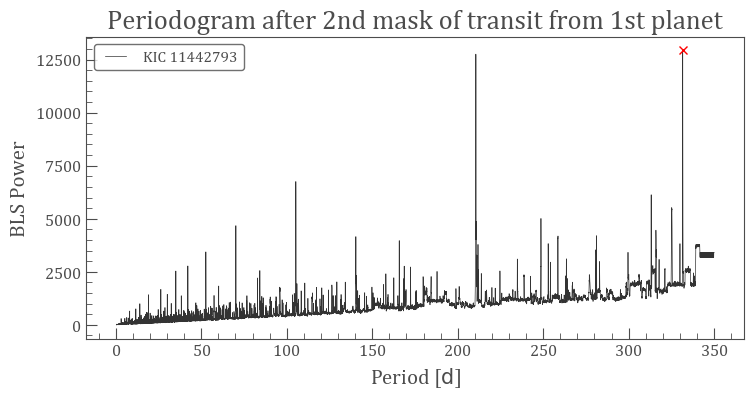

In [10]:
lc_mask2 = rem_periodo.get_transit_mask(period=rem_periodo.period_at_max_power, 
                                      duration=rem_periodo.duration_at_max_power,
                                      transit_time=rem_periodo.transit_time_at_max_power)
clc_rem2 = clc_rem[lc_mask2]

rem_periodo2 = clc_rem2.to_periodogram(method="bls", period=np.linspace(0.3, 350, 10000))
ax = rem_periodo2.plot()
ax.plot(rem_periodo2.period_at_max_power, rem_periodo2.max_power, 'rx')
ax.set_title('Periodogram after 2nd mask of transit from 1st planet')

In [11]:
rem_bestfit2 = rem_periodo2.period_at_max_power
print('Kepler-90 searching for planet 2 best fit period: {:.3f}'.format(rem_bestfit2))

Kepler-90 searching for planet 2 best fit period: 331.604 d


### 3rd mask, 1st planet

`period` contains 2837711 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


Text(0.5, 1.0, 'Periodogram after 3rd mask of transit from 1st planet')

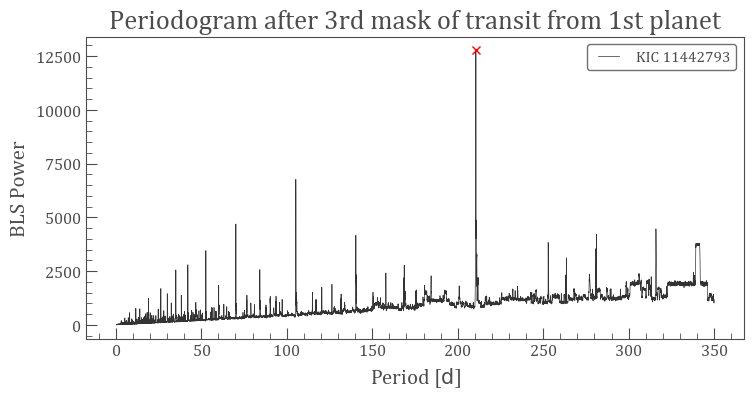

In [12]:
lc_mask3 = rem_periodo2.get_transit_mask(period=rem_periodo2.period_at_max_power, 
                                      duration=rem_periodo2.duration_at_max_power,
                                      transit_time=rem_periodo2.transit_time_at_max_power)
clc_rem3 = clc_rem2[lc_mask3]

rem_periodo3 = clc_rem3.to_periodogram(method="bls", period=np.linspace(0.3, 350, 10000))
ax = rem_periodo3.plot()
ax.plot(rem_periodo3.period_at_max_power, rem_periodo3.max_power, 'rx')
ax.set_title('Periodogram after 3rd mask of transit from 1st planet')

In [13]:
rem_bestfit3 = rem_periodo3.period_at_max_power
print('Kepler-90 searching for planet 2 best fit period: {:.3f}'.format(rem_bestfit3))

Kepler-90 searching for planet 2 best fit period: 210.596 d


Finally! With that 331.604 d period gone, we find our next planet.

## Second planet

Kepler-90 planet 2 best fit period: 210.596 d


Text(0.5, 1.0, '2nd planet found')

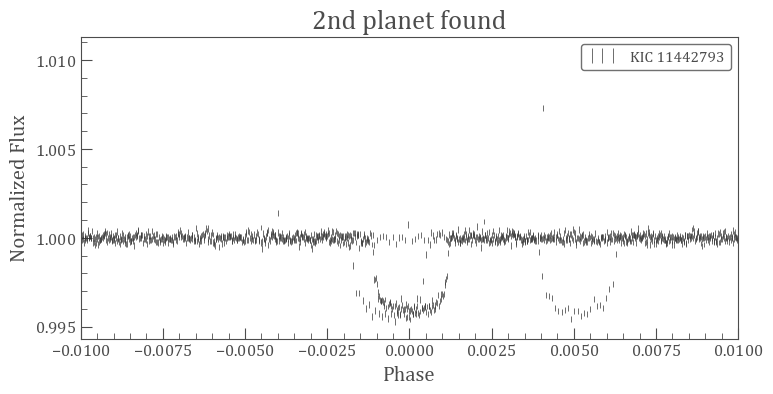

In [14]:
print('Kepler-90 planet 2 best fit period: {:.3f}'.format(rem_bestfit3))
ax = clc_rem3.fold(period=rem_bestfit3, t0=rem_periodo3.transit_time_at_max_power).errorbar()
ax.set_xlim(-0.01, 0.01)
ax.set_title('2nd planet found')

## Mask transit from 2nd planet
Hopefully this doesn't take as many iterations as last time.

`period` contains 2837711 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


Text(0.5, 1.0, 'Periodogram after 1st mask of transit from 2nd planet')

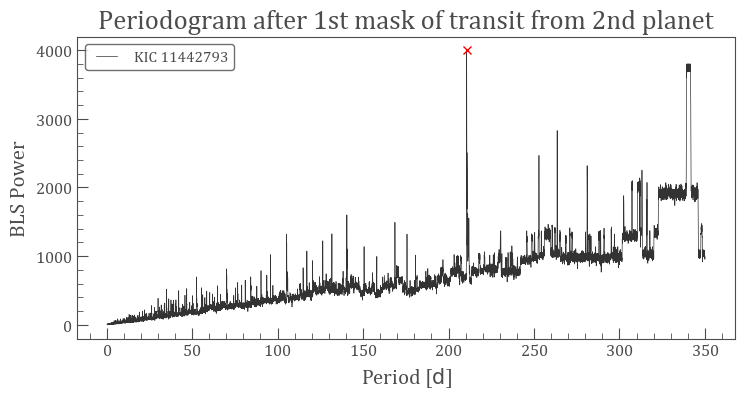

In [15]:
lc_mask_planet2 = rem_periodo3.get_transit_mask(period=rem_periodo3.period_at_max_power, 
                                      duration=rem_periodo3.duration_at_max_power,
                                      transit_time=rem_periodo3.transit_time_at_max_power)
clc_rem_planet2 = clc_rem3[lc_mask_planet2]

rem_periodo_planet2 = clc_rem_planet2.to_periodogram(method="bls", period=np.linspace(0.3, 350, 10000))
ax = rem_periodo_planet2.plot()
ax.plot(rem_periodo_planet2.period_at_max_power, rem_periodo_planet2.max_power, 'rx')
ax.set_title('Periodogram after 1st mask of transit from 2nd planet')

In [16]:
rem_bestfit_planet2 = rem_periodo_planet2.period_at_max_power
print('Kepler-90 searching for planet 3 best fit period: {:.3f}'.format(rem_bestfit_planet2))

Kepler-90 searching for planet 3 best fit period: 210.596 d


### 2nd mask, 2nd planet

`period` contains 2837711 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


Text(0.5, 1.0, 'Periodogram after 2nd mask of transit from 2nd planet')

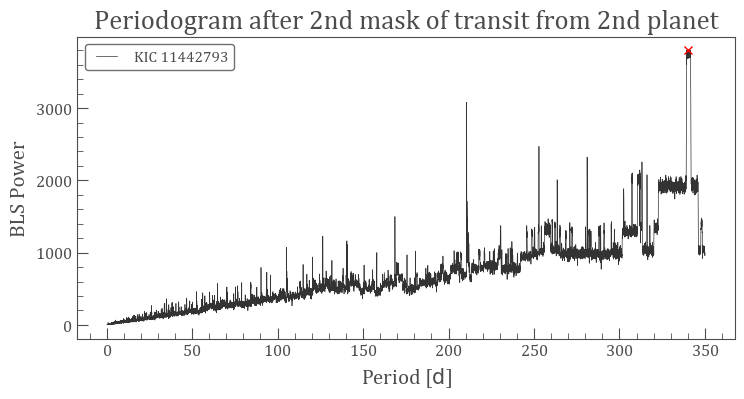

In [17]:
lc_mask_planet2_2 = rem_periodo_planet2.get_transit_mask(period=rem_periodo_planet2.period_at_max_power, 
                                      duration=rem_periodo_planet2.duration_at_max_power,
                                      transit_time=rem_periodo_planet2.transit_time_at_max_power)
clc_rem_planet2_2 = clc_rem_planet2[lc_mask_planet2_2]

rem_periodo_planet2_2 = clc_rem_planet2_2.to_periodogram(method="bls", period=np.linspace(0.3, 350, 10000))
ax = rem_periodo_planet2_2.plot()
ax.plot(rem_periodo_planet2_2.period_at_max_power, rem_periodo_planet2_2.max_power, 'rx')
ax.set_title('Periodogram after 2nd mask of transit from 2nd planet')

In [18]:
rem_bestfit_planet2_2 = rem_periodo_planet2_2.period_at_max_power
print('Kepler-90 searching for planet 3 best fit period: {:.3f}'.format(rem_bestfit_planet2_2))

Kepler-90 searching for planet 3 best fit period: 339.893 d


Ugh. I am going to go ahead and use some _prior_ knowledge about these periods and simply truncate my search for a period of <150 days for the next planet.

### Truncating period search range, 3rd planet

`period` contains 2834465 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


Kepler-90 planet 3 best fit period: 126.450 d


Text(0.5, 1.0, '3rd planet found')

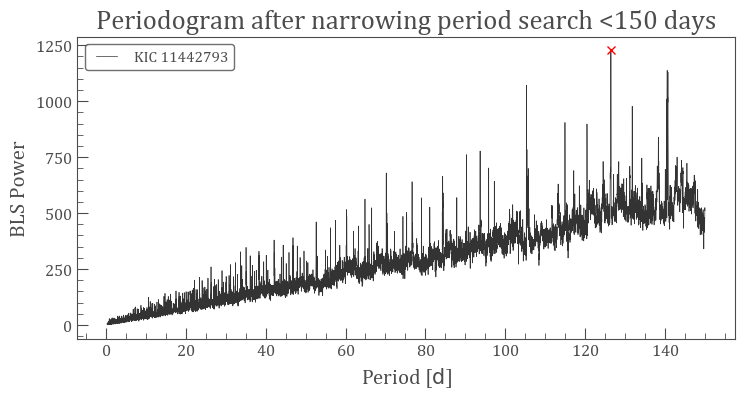

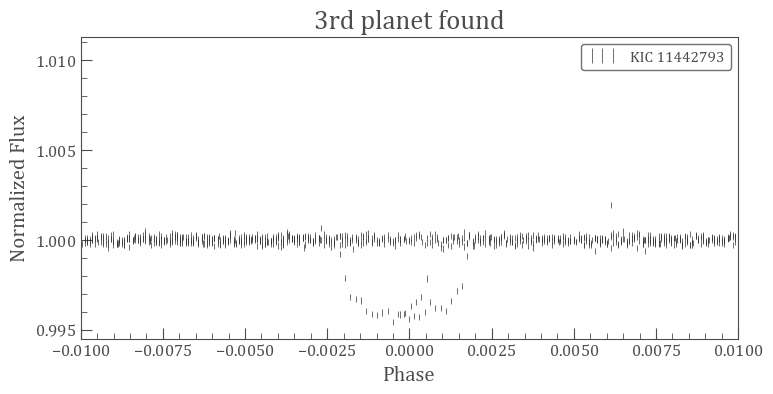

In [19]:
rem_periodo_planet3 = clc_rem_planet2_2.to_periodogram(method="bls", period=np.linspace(0.3, 150, 10000))
ax = rem_periodo_planet3.plot()
ax.plot(rem_periodo_planet3.period_at_max_power, rem_periodo_planet3.max_power, 'rx')
ax.set_title('Periodogram after narrowing period search <150 days')


rem_bestfit_planet3 = rem_periodo_planet3.period_at_max_power
print('Kepler-90 planet 3 best fit period: {:.3f}'.format(rem_bestfit_planet3))
ax = clc_rem_planet2_2.fold(period=rem_bestfit_planet3, t0=rem_periodo_planet3.transit_time_at_max_power).errorbar()
ax.set_xlim(-0.01, 0.01)
ax.set_title('3rd planet found')

Ehhh... that's not as tight as it could be, but it's not terrible. Knowing that the true period for this planet is 124.914 days, I'll call this a win.

# JUNK BELOW HERE (but useful(?) in my process)

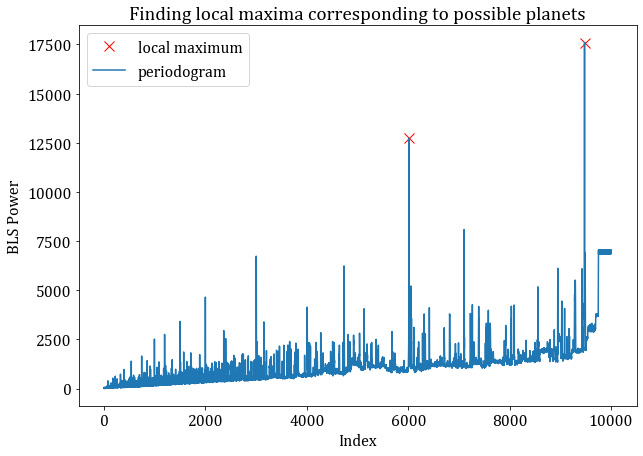

In [20]:
peaks, _ = find_peaks(rem_periodo.power, height=10000, distance=300)
powerarr = rem_periodo.power

plt.figure(figsize=(10,7))
plt.plot(peaks, powerarr[peaks], 'rx', ms=10, label='local maximum')
plt.plot(powerarr, label='periodogram')
plt.xlabel('Index')
plt.ylabel('BLS Power')
plt.title('Finding local maxima corresponding to possible planets')
plt.legend()
plt.show()

[210.59563956 331.60394039] d
lightkurve.Periodogram properties:
        Attribute            Description     Units
------------------------- ------------------ -----
                 targetid           11442793      
             default_view             period      
                    label       KIC 11442793      
                time_unit                day      
       depth_at_max_power             0.0082      
    duration_at_max_power               0.25     d
   frequency_at_max_power              0.003 1 / d
                max_power         40526.5653      
      period_at_max_power           331.6039     d
transit_time_at_max_power           140.5124      
                    depth     array (10000,)      
                 duration     array (10000,)     d
                     flux     array (51503,)      
                frequency     array (10000,) 1 / d
                   period     array (10000,)     d
                    power     array (10000,)      
                 

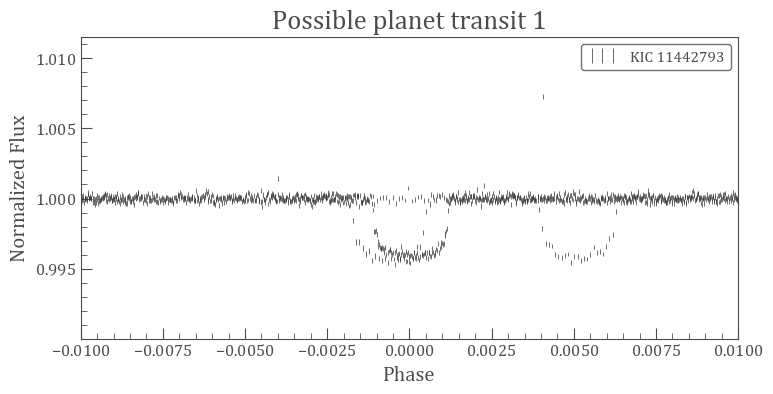

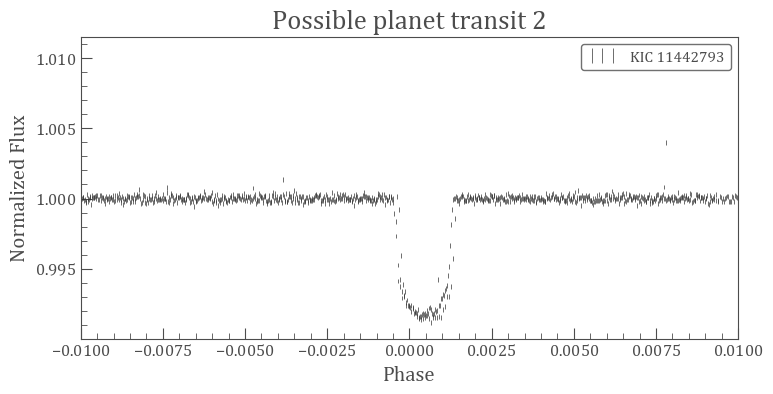

In [21]:
periodarr = rem_periodo.period
transitarr = rem_periodo.transit_time
poss_planet_periods = periodarr[peaks]
poss_planet_transit = transitarr[peaks]
print(poss_planet_periods)

clc_periodo.show_properties()

for idx, val in enumerate(poss_planet_periods):
    print('Kepler-90 peak {} possible period: {:.3f}'.format(idx, val))
    ax = clc.fold(period=val, t0=poss_planet_transit[idx]).errorbar()
    ax.set_xlim(-0.01, 0.01)
    ax.set_title('Possible planet transit {}'.format(idx+1))

# Mel attempting with lightkurve

In [22]:
true_periods = np.array([7.008, 8.719, 59.737, 91.939, 124.914, 210.607, 331.601, 14.449]) # archive

def percent_error(found, true):
    return 100*abs((true-found)/true)
    
period_search = [np.linspace(6.3, 7.5, 10000), np.linspace(7.8, 9, 10000),
           np.linspace(59, 60.2, 10000), np.linspace(91.3, 92.5, 10000),
           np.linspace(124.3, 125.5, 10000), np.linspace(210, 211.2, 10000),
           np.linspace(330.8, 332, 10000), np.linspace(13.8, 15, 10000)]

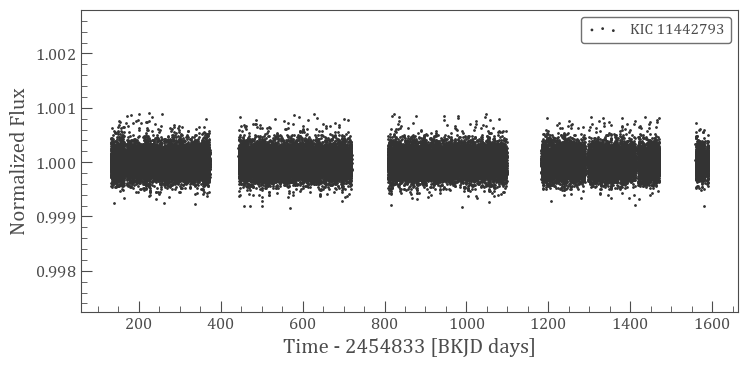

In [23]:
# try to do above tutorial on Kepler-90
clc_noout = clc.remove_outliers()
clc_noout.scatter()

Kepler-90 0 planet best fit period: 7.008 d
Kepler-90 1 planet best fit period: 8.720 d
Kepler-90 2 planet best fit period: 59.736 d
Kepler-90 3 planet best fit period: 91.938 d
Kepler-90 4 planet best fit period: 124.921 d
Kepler-90 5 planet best fit period: 211.021 d
Kepler-90 6 planet best fit period: 331.571 d
Kepler-90 7 planet best fit period: 14.935 d


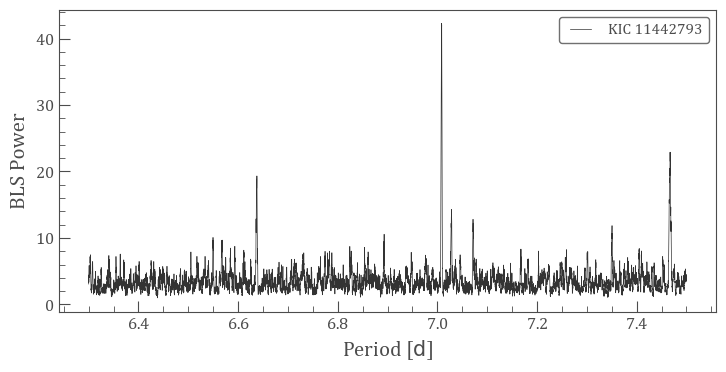

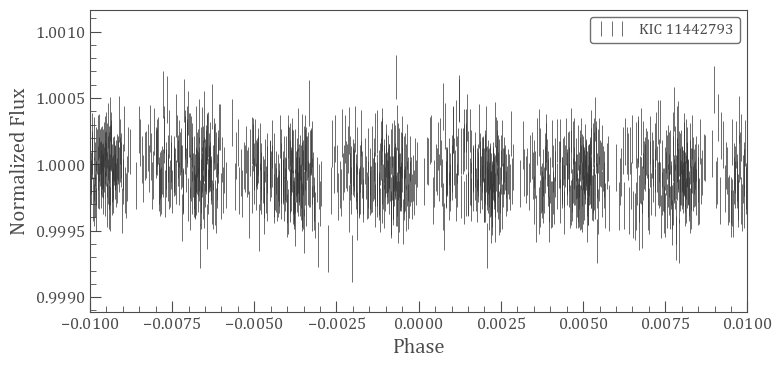

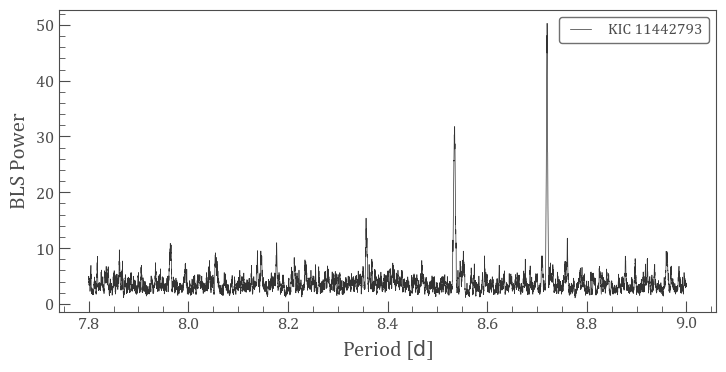

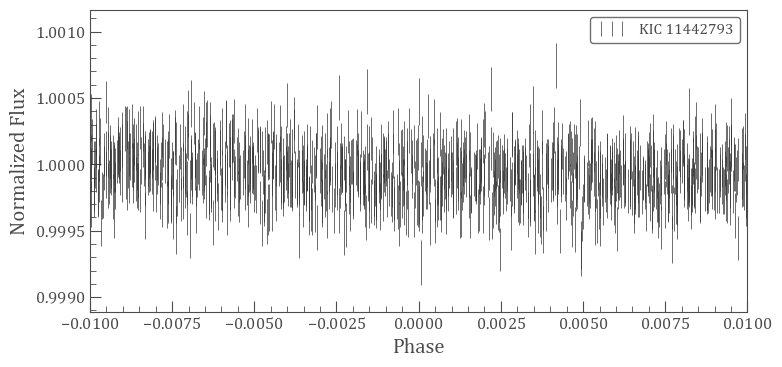

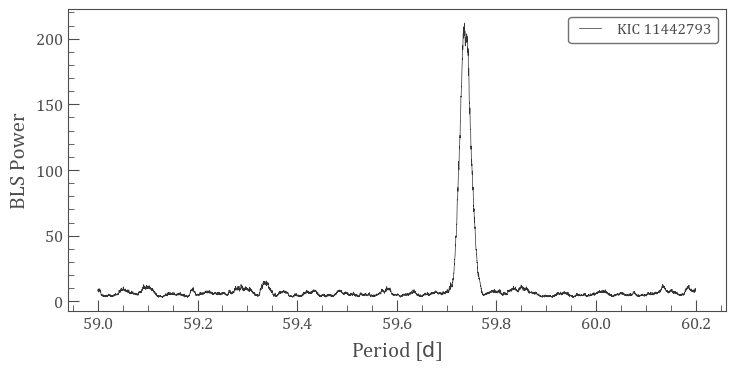

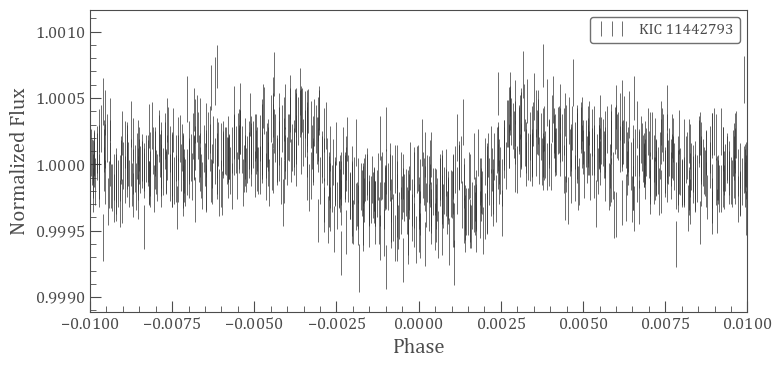

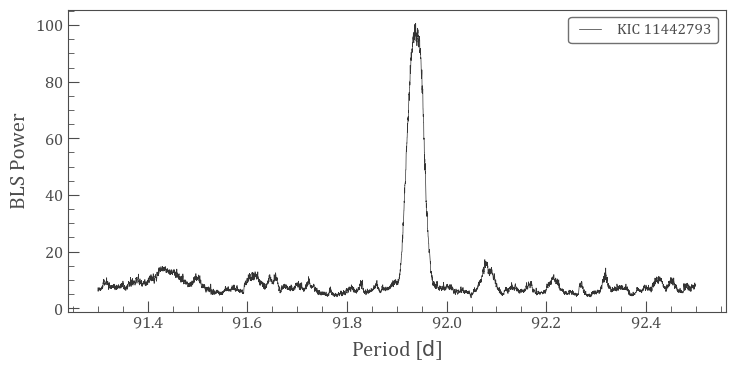

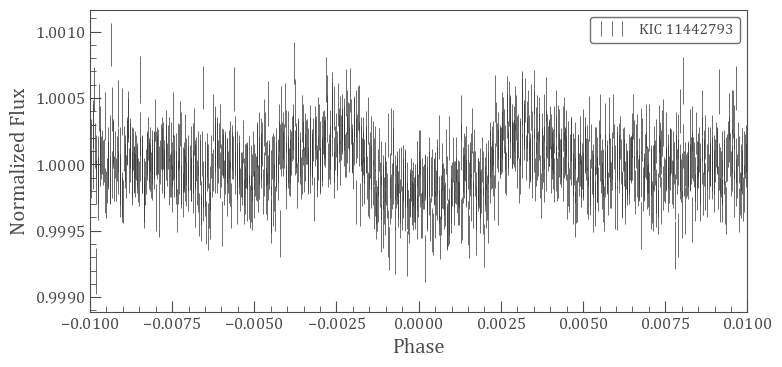

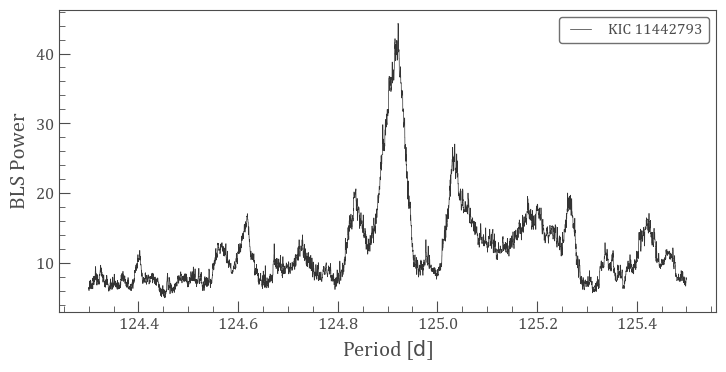

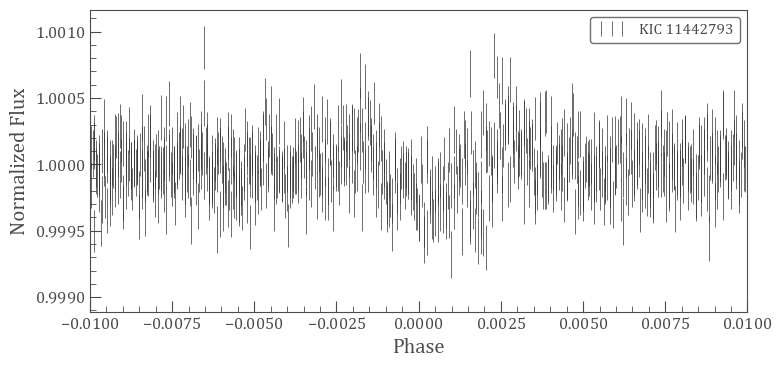

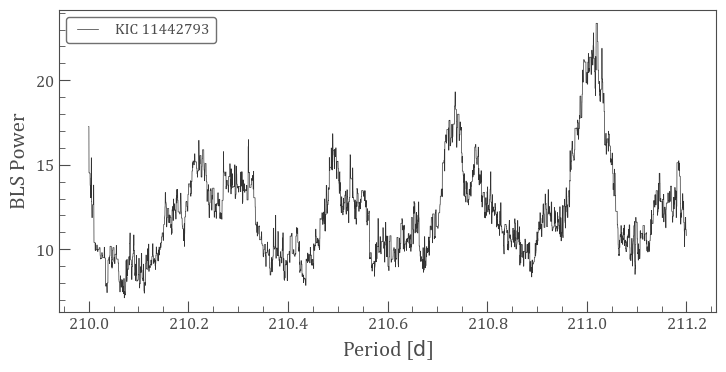

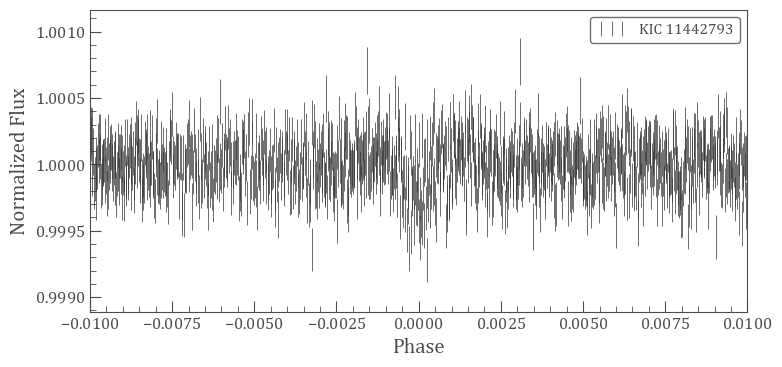

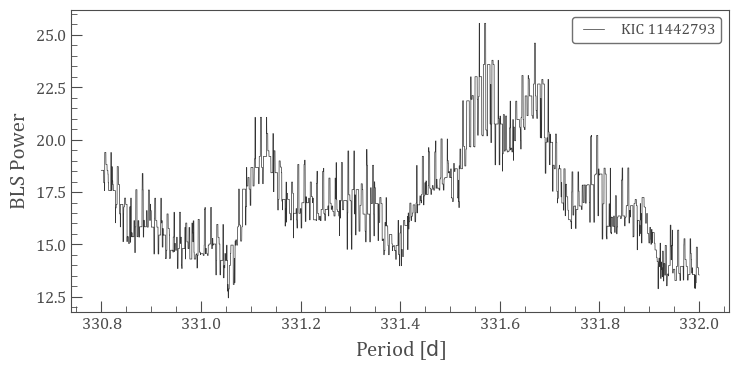

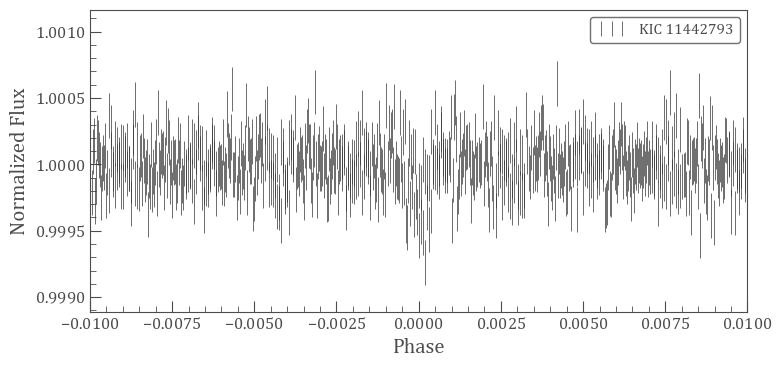

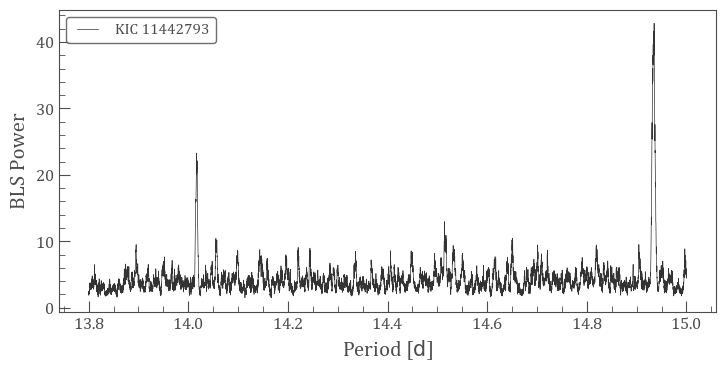

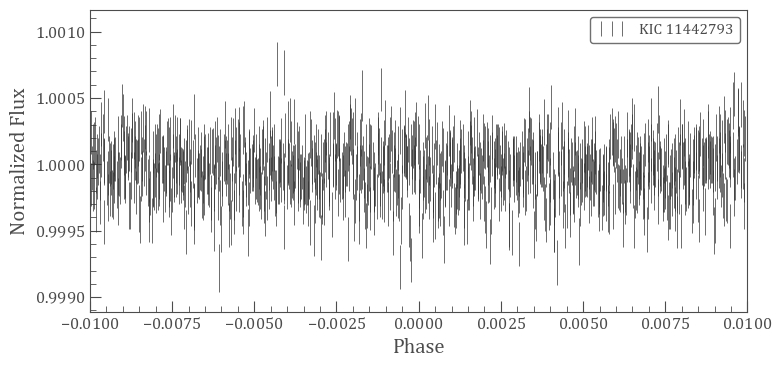

In [24]:
found_periods = np.array([])
for i, period in enumerate(period_search):
    clc_periodo = clc_noout.to_periodogram(method="bls", period=period)
    clc_periodo.plot()
    clc_best = clc_periodo.period_at_max_power
    found_periods = np.append(found_periods, clc_best.value)
    print('Kepler-90 {} planet best fit period: {:.3f}'.format(i, clc_best))
    ax = clc_noout.fold(period=clc_best, t0=clc_periodo.transit_time_at_max_power).errorbar()
    ax.set_xlim(-0.01, 0.01)

In [25]:
error_vals = percent_error(found_periods, true_periods)
for idx, val in enumerate(error_vals):
    print('Percent error for planet {} is {}%.'.format(idx, round(val,4)))

Percent error for planet 0 is 0.0044%.
Percent error for planet 1 is 0.0144%.
Percent error for planet 2 is 0.0018%.
Percent error for planet 3 is 0.0014%.
Percent error for planet 4 is 0.0057%.
Percent error for planet 5 is 0.1966%.
Percent error for planet 6 is 0.009%.
Percent error for planet 7 is 3.3641%.


How close the chosen largest power from the periodogram is often very close to the true periods. Looking at some of the periodograms, though, the peaks are not so obvious, and the lack of clarity continues with the corresponding folded phase plots.

## Hmm... what if I wasn't searching so close to the true periods?
### Can I still pick out 3 planets from the strongest periodogram peaks?

`period` contains 167974 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


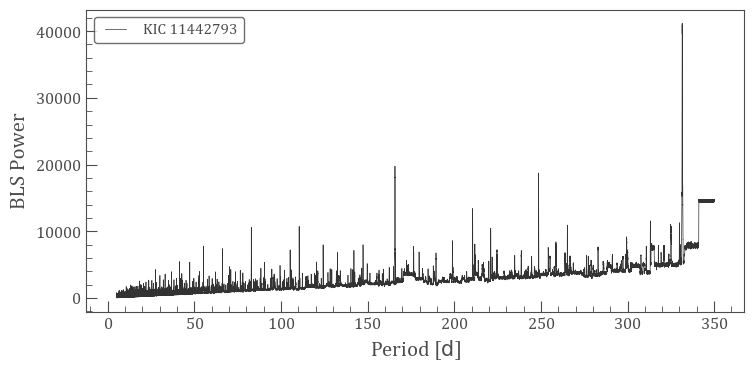

In [26]:
clc_period = clc.to_periodogram(method="bls", period=np.linspace(5, 350, 100000))
clc_period.plot()

#clc_best = clc_period.period_at_max_power
#print('Kepler-90 {} planet best fit period: {:.3f}'.format(i, clc_best))

#flat.fold(period=clc_best, t0=clc_period.transit_time_at_max_power).errorbar()

In [27]:
print(np.argmax(clc_period.power))
print(max(clc_period.frequency))

94659
0.2 1 / d


# Mel using gatspy

In [28]:
# gatspy tutorial
model = gp.periodic.LombScargle()
model.optimizer.period_range = (6, 7.5)
model.fit(clc_noout.time, clc_noout.flux)

print(model.best_period)

tfit = np.linspace(0, model.best_period, 4)
model.predict(tfit)

Finding optimal frequency:
 - Estimated peak width = 0.00431
 - Using 5 steps per peak; omega_step = 0.000861
 - User-specified period range:  6 to 7.5
 - Computing periods at 245 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
7.388525846359801


array([1.00000068, 1.00000256, 1.00000075, 1.00000068])